### Imports

In [3]:
from sklearn.datasets import fetch_lfw_people
from matplotlib import pyplot as plt
from matplotlib.pyplot import imread
import numpy as np
import seaborn as sns
import scipy

import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras import metrics # https://keras.io/metrics/ - ver a parte de custom metrics
from keras.callbacks import History 
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


### Funções minhas

In [4]:
# Adicionando ruído às imagens
def add_noise(sigma, bw_img):
    """Adiciona ruído a uma imagem em escala de cinza com valores entre 0 e 1"""
    sh = bw_img.shape
    noise = np.random.normal(0, sigma, sh)
    newgray = bw_img + noise
    #np.clip(newgray, 0, 1) # quando faço isso ela deixa de ser normal!!!
    # vou parar de clipar.
    return newgray


def plota_pra_mim_pfv(pred, numero):
    figures, axes = plt.subplots(1,3)
    axes[0].imshow(faces[numero].reshape(60, 44), cmap = 'gray')
    axes[0].set_title('Original image')
    axes[1].imshow(newfaces[numero].reshape(60, 44), cmap = 'gray')
    axes[1].set_title('Input (noisy image)')
    axes[2].imshow(pred[numero].reshape(60, 44), cmap = 'gray')
    axes[2].set_title('Reconstructed')

### Base de dados

In [5]:
db = fetch_lfw_people()

In [6]:
faces = db['data']
total_imagens = len(faces)
faces_matrix = np.empty((total_imagens, 60, 44))

for i in range(total_imagens):
    faces_matrix[i] = faces[i].reshape(62, 47)[1:61, 1:45]

# Normalizando imagens
faces_matrix = faces_matrix/np.amax(faces_matrix)

# Adicionando ruído
del faces
faces = faces_matrix
newfaces = add_noise(0.05, faces)

newfaces = newfaces.reshape(-1, 60, 44, 1)
faces = faces.reshape(-1, 60, 44, 1)

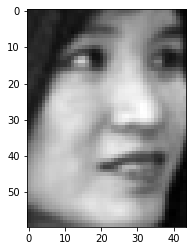

In [7]:
plt.imshow(faces_matrix[4], cmap = 'gray')

### Escolhendo métricas que serão monitoradas

In [8]:
# Funções custo e métricas podem ser utilizadas como métricas
metricas = [ ###### LOSSES:
            'mean_squared_error', 'mean_absolute_error', 'cosine_proximity',
            'mean_absolute_percentage_error', 'mean_squared_logarithmic_error',
            #'hinge', 'squared_hinge', 'logcosh', 'binary_crossentropy', 
            #'huber_loss', 
            'kullback_leibler_divergence',
            #'poisson',
             ###### METRICS:
            'accuracy', 'binary_accuracy'] # as outras metrics são categóricas.

## Fixando arquitetura, variando codigo

## Compilando modelo

In [9]:
# Real:
fatores1 = (1, 2, 4, 12, 20)
fatores2 = (1, 2, 4)
# Para teste:
fatores1 = (1, 2)
fatores2 = (1, 2)

autoencoders = [None] * len(fatores1) * len(fatores2)
historias = [None] * len(fatores1) * len(fatores2)
cont = 0

for i in fatores1:
  for j in fatores2:
    def make_autoencoder():
      # encoding
      inputs = Input(shape=(60, 44, 1)) 
      x = Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same')(inputs) 
      x = MaxPooling2D(pool_size = (i, j), padding = 'same')(x)
      x = Conv2D(filters = 8, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x) 
      encoded = MaxPooling2D(padding = 'same')(x)
      
      # decoding
      x = UpSampling2D(size = (i, j))(x)
      decoded = Conv2D(filters = 1, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')(x) 
      
      # autoencoder compilation
      autoencoder = Model(inputs, decoded)
      autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = metricas)
      return autoencoder
    autoencoders[cont] = make_autoencoder()
    historias[cont] = History()
    cont += 1

### Fittando

In [ ]:
cont = 0
for i in fatores1:
  for j in fatores2:
    autoencoders[cont].fit(newfaces, faces, epochs=25, batch_size=128, callbacks=[historias[cont]], validation_split = 0.1)
    cont += 1

Train on 11909 samples, validate on 1324 samples
Epoch 1/25
11909/11909 [==============================] - 22s 2ms/step - loss: 0.6249 - mean_squared_error: 7.1518e-04 - mean_absolute_error: 0.0207 - cosine_proximity: 1.0000 - mean_absolute_percentage_error: 870.6744 - mean_squared_logarithmic_error: 3.2650e-04 - kullback_leibler_divergence: 8.8173e-04 - accuracy: 5.6902e-05 - binary_accuracy: 5.6902e-05 - val_loss: 0.6237 - val_mean_squared_error: 7.0652e-04 - val_mean_absolute_error: 0.0205 - val_cosine_proximity: 1.0000 - val_mean_absolute_percentage_error: 467.9577 - val_mean_squared_logarithmic_error: 3.2122e-04 - val_kullback_leibler_divergence: 0.0018 - val_accuracy: 5.0066e-05 - val_binary_accuracy: 5.0066e-05
Epoch 2/25
11909/11909 [==============================] - 24s 2ms/step - loss: 0.6249 - mean_squared_error: 7.1425e-04 - mean_absolute_error: 0.0207 - cosine_proximity: 1.0000 - mean_absolute_percentage_error: 874.8143 - mean_squared_logarithmic_error: 3.2628e-04 - kullba

Epoch 13/25
11909/11909 [==============================] - 35s 3ms/step - loss: 0.6248 - mean_squared_error: 6.7350e-04 - mean_absolute_error: 0.0201 - cosine_proximity: 1.0000 - mean_absolute_percentage_error: 873.1124 - mean_squared_logarithmic_error: 3.1146e-04 - kullback_leibler_divergence: 8.6880e-04 - accuracy: 5.6902e-05 - binary_accuracy: 5.6902e-05 - val_loss: 0.6235 - val_mean_squared_error: 6.6670e-04 - val_mean_absolute_error: 0.0200 - val_cosine_proximity: 1.0000 - val_mean_absolute_percentage_error: 480.8409 - val_mean_squared_logarithmic_error: 3.0723e-04 - val_kullback_leibler_divergence: 0.0011 - val_accuracy: 5.0066e-05 - val_binary_accuracy: 5.0066e-05
Epoch 14/25
11909/11909 [==============================] - 37s 3ms/step - loss: 0.6248 - mean_squared_error: 6.6998e-04 - mean_absolute_error: 0.0200 - cosine_proximity: 1.0000 - mean_absolute_percentage_error: 865.2783 - mean_squared_logarithmic_error: 3.1014e-04 - kullback_leibler_divergence: 8.4154e-04 - accuracy: 5

### Predizendo

In [55]:
predicoes = [None] * len(fatores1) * len(fatores2)
cont = 0

for i in fatores1:
  for j in fatores2:
    predicoes[cont] = autoencoders[cont].predict(faces)
    cont += 1

In [56]:
cont = 0
fator = [None] * len(fatores1) * len(fatores2)


for i in fatores1:
  for j in fatores2:
    fator[cont] = (i, j)
    cont += 1
    

### Resultados

Model: "model_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        (None, 60, 44, 1)         0         
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 60, 44, 16)        160       
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 60, 44, 16)        0         
_________________________________________________________________
conv2d_152 (Conv2D)          (None, 60, 44, 8)         1160      
_________________________________________________________________
up_sampling2d_51 (UpSampling (None, 60, 44, 8)         0         
_________________________________________________________________
conv2d_153 (Conv2D)          (None, 60, 44, 1)         73        
Total params: 1,393
Trainable params: 1,393
Non-trainable params: 0
________________________________________________________

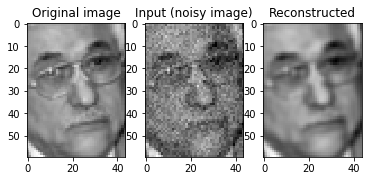

In [57]:
plota_pra_mim_pfv(predicoes[0], 1)
autoencoders[0].summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 60, 44, 1)         0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 60, 44, 16)        160       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 60, 22, 16)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 60, 22, 8)         1160      
_________________________________________________________________
up_sampling2d_17 (UpSampling (None, 60, 44, 8)         0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 60, 44, 1)         73        
Total params: 1,393
Trainable params: 1,393
Non-trainable params: 0
________________________________________________________

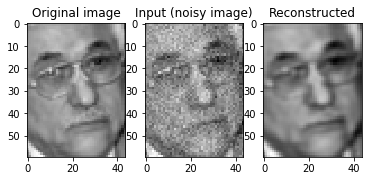

In [63]:
plota_pra_mim_pfv(predicoes[1], 1)
autoencoders[1].summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 60, 44, 1)         0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 60, 44, 16)        160       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 60, 11, 16)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 60, 11, 8)         1160      
_________________________________________________________________
up_sampling2d_18 (UpSampling (None, 60, 44, 8)         0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 60, 44, 1)         73        
Total params: 1,393
Trainable params: 1,393
Non-trainable params: 0
________________________________________________________

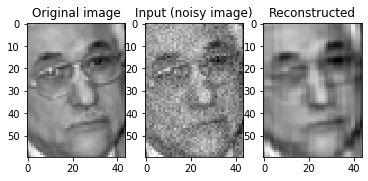

In [64]:
plota_pra_mim_pfv(predicoes[2], 1)
autoencoders[2].summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 60, 44, 1)         0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 60, 44, 16)        160       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 30, 44, 16)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 30, 44, 8)         1160      
_________________________________________________________________
up_sampling2d_19 (UpSampling (None, 60, 44, 8)         0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 60, 44, 1)         73        
Total params: 1,393
Trainable params: 1,393
Non-trainable params: 0
________________________________________________________

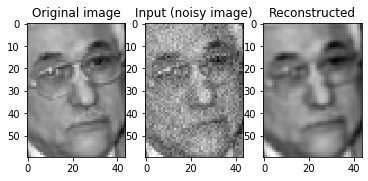

In [62]:
plota_pra_mim_pfv(predicoes[3], 1)
autoencoders[3].summary()

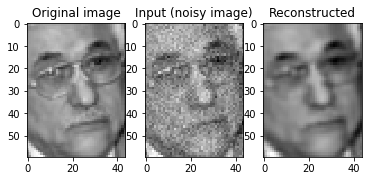

In [42]:
plota_pra_mim_pfv(predicoes[4], 1)

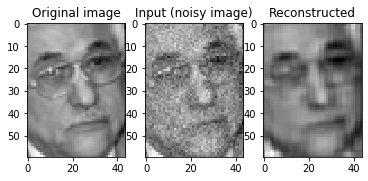

In [43]:
plota_pra_mim_pfv(predicoes[5], 1)

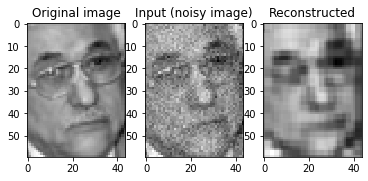

In [46]:
plota_pra_mim_pfv(predicoes[8], 1)

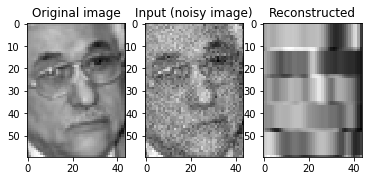

In [47]:
plota_pra_mim_pfv(predicoes[9], 1)

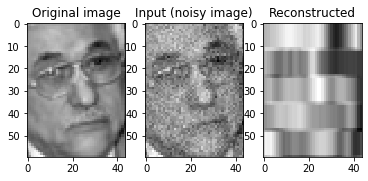

In [48]:
plota_pra_mim_pfv(predicoes[10], 1)

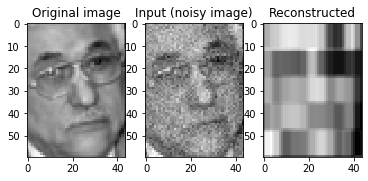

In [49]:
plota_pra_mim_pfv(predicoes[11], 1)

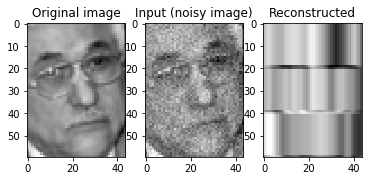

In [50]:
plota_pra_mim_pfv(predicoes[12], 1)

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 60, 44, 1)         0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 60, 44, 16)        160       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 3, 22, 16)         0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 3, 22, 8)          1160      
_________________________________________________________________
up_sampling2d_29 (UpSampling (None, 60, 44, 8)         0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 60, 44, 1)         73        
Total params: 1,393
Trainable params: 1,393
Non-trainable params: 0
________________________________________________________

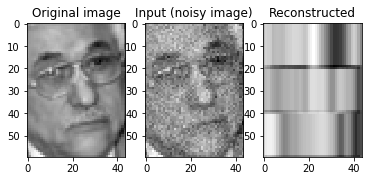

In [66]:
plota_pra_mim_pfv(predicoes[13], 1)
autoencoders[13].summary()

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 60, 44, 1)         0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 60, 44, 16)        160       
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 3, 11, 16)         0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 3, 11, 8)          1160      
_________________________________________________________________
up_sampling2d_30 (UpSampling (None, 60, 44, 8)         0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 60, 44, 1)         73        
Total params: 1,393
Trainable params: 1,393
Non-trainable params: 0
________________________________________________________

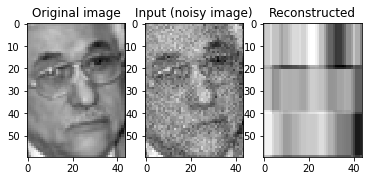

In [67]:
plota_pra_mim_pfv(predicoes[14], 1)
autoencoders[14].summary()

### Salvando objetos

In [58]:
for i in range(len(fatores1) * len(fatores2)):
    autoencoders[i].save("autoencoders%i" % i)

## Plotando métricas por epoch

In [60]:
# tem que botar callbacks=[history] no momento do fit.
print(historias[0].history)

{'loss': [0.6263171215271054, 0.6258155853806155, 0.6255061914615779, 0.6253106775516593, 0.6251631708747989, 0.625071120863012, 0.6250368366478919, 0.6249772686811654, 0.6249579852971235, 0.6249385578448762, 0.6249187965877002, 0.6248951692984036, 0.6248906732713574, 0.6248843239601044, 0.6248921008775954, 0.624872386716782, 0.624876657049735, 0.624875347882561, 0.6248483689591826, 0.6248637329448353, 0.624842973322246, 0.6248296267824325, 0.6248428272676695, 0.6248250089336359, 0.6248349360144797], 'mean_squared_error': [0.0012840093, 0.0010783204, 0.000956996, 0.0008853017, 0.00083182286, 0.0007993744, 0.00078973337, 0.00076748943, 0.0007623245, 0.00075565366, 0.0007487452, 0.0007399533, 0.00073887553, 0.0007372129, 0.0007414284, 0.00073327764, 0.0007358715, 0.00073564734, 0.00072404754, 0.0007314177, 0.0007227169, 0.0007172185, 0.00072346715, 0.0007160406, 0.0007210436], 'mean_absolute_error': [0.02523484, 0.023949984, 0.02304349, 0.02249761, 0.021969853, 0.021636236, 0.021579234, 

Text(0.5, 1.0, 'kullback_leibler_divergence')

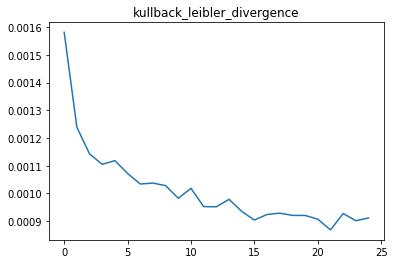

In [70]:
metrica = metricas[5]
cont = 0
sns.lineplot(range(len(historias[cont].history[metrica])), historias[cont].history[metrica]).set_title(metrica)

Text(0.5, 1.0, 'mean_squared_error')

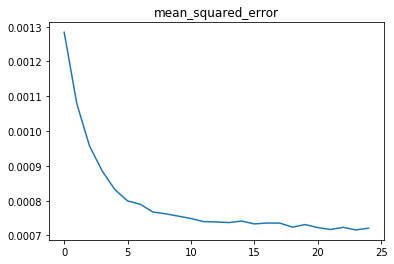

In [72]:
metrica = metricas[0]
cont = 0
sns.lineplot(range(len(historias[cont].history[metrica])), historias[cont].history[metrica]).set_title(metrica)

Text(0.5, 1.0, 'loss')

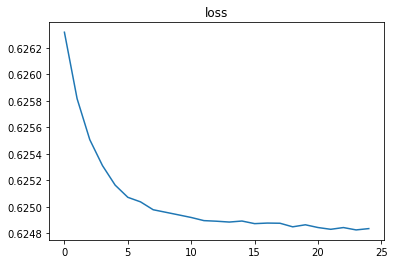

In [80]:
metrica = 'loss'
cont = 0
sns.lineplot(range(len(historias[cont].history[metrica])), historias[cont].history[metrica]).set_title(metrica)
# nesse caso loss é a binary cross entropy

### Para salvar o history vou ter que usar o pickle. O .save() do keras não salva o histórico

In [10]:
import pickle

In [15]:
pickle.dump(historias, open( "save_historias", "wb" ) )

## Carregando objetos em outra sessão

In [2]:
from keras.models import load_model
modelo = load_model('autoencoders0')

certas características tipo training history e variáveis de contexto que afetam mais a usabilidade não são salvas, só coisas tipo pesos da rede mesmo que são salvas.

por isso tive que usar o pickle pra salvar a lista das historias

In [ ]:
historias = pickle.load( open( "save_historias", "rb" ) )

In [3]:
type(modelo)

keras.engine.training.Model

In [6]:
modelo

In [4]:
modelo.summary()

Model: "model_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        (None, 60, 44, 1)         0         
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 60, 44, 16)        160       
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 60, 44, 16)        0         
_________________________________________________________________
conv2d_152 (Conv2D)          (None, 60, 44, 8)         1160      
_________________________________________________________________
up_sampling2d_51 (UpSampling (None, 60, 44, 8)         0         
_________________________________________________________________
conv2d_153 (Conv2D)          (None, 60, 44, 1)         73        
Total params: 1,393
Trainable params: 1,393
Non-trainable params: 0
________________________________________________________

Queria plotar os pesos como uma imagem, mas não to conseguindo entender esse objeto modelo.weights

In [50]:
np.array(modelo.weights[0])

array(<tf.Variable 'conv2d_151/kernel:0' shape=(3, 3, 1, 16) dtype=float32, numpy=
array([[[[ 0.05724442,  0.19854532, -0.08246384, -0.04647661,
          -0.01548494,  0.14917083, -0.24050637, -0.07443369,
          -0.0086793 ,  0.02763049,  0.1303676 ,  0.09324955,
           0.1768916 ,  0.05725028, -0.01016349, -0.00129684]],

        [[-0.09474679,  0.17755261, -0.08535835,  0.16020219,
           0.00260242,  0.12172101, -0.26698017, -0.12618814,
          -0.02596833, -0.08150528,  0.03549315, -0.05744288,
           0.17142555, -0.04370416,  0.15633373,  0.17304184]],

        [[-0.18500896, -0.03662722,  0.06418329, -0.03595619,
          -0.04237462, -0.01223998, -0.29903618, -0.07475214,
           0.11886081, -0.1482142 ,  0.15922378,  0.25540707,
          -0.07779668,  0.03951329,  0.12030627, -0.15612186]]],


       [[[ 0.20174679,  0.10179184,  0.26875004,  0.16397482,
          -0.01692513,  0.01361868,  0.0408058 ,  0.05424308,
          -0.06474304,  0.1983375 , -0

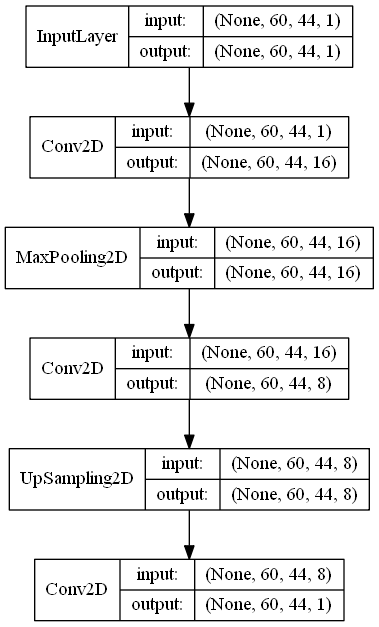

In [7]:
# jeito melhor de visualizar a arquitetura
plot_model(modelo, show_shapes=True, show_layer_names=False)

In [8]:
def plot_conv_weights(model, layer):
    W = model.get_layer(name=layer).get_weights()[0]
    if len(W.shape) == 4:
        W = np.squeeze(W)
        W = W.reshape((W.shape[0], W.shape[1], W.shape[2]*W.shape[3])) 
        fig, axs = plt.subplots(5,5, figsize=(8,8))
        fig.subplots_adjust(hspace = .5, wspace=.001)
        axs = axs.ravel()
        for i in range(25):
            axs[i].imshow(W[:,:,i])
            axs[i].set_title(str(i))

In [13]:
plot_conv_weights(modelo, 1)

TypeError: can only concatenate str (not "int") to str